# Contents:



*   [Data](https://www2.aueb.gr/users/ion/data/enron-spam/)
*   [Exploring Data](#exp)
*   [Text Preprocessing](#preproc)
*   [Naive Bayes Implementation](#nai)
*   [Testing](#tst)
*   [Evaluation](#eva)
*   [Cross Validation and Hyper Tunning](#cross-va)





# Libraries:

In [74]:
import glob, os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict

from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score, classification_report, roc_auc_score

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

<a name = 'exp'></a>
# Data:

In [3]:
#!tar -xzvf "/content/drive/MyDrive/enron1.tar.gz" -C "/content/drive/MyDrive/"  

In [4]:
# Number of ham messages:
!ls -l /content/drive/MyDrive/enron1/ham/*.txt  | wc -l

3672


In [5]:
# Number of spam messages:
!ls -l /content/drive/MyDrive/enron1/spam/*.txt  | wc -l

1500


## Look at ham example:

In [6]:
file_path = "/content/drive/MyDrive/enron1/ham/0007.1999-12-14.farmer.ham.txt"
with open(file_path, 'r') as file:
  hamsample = file.read()


In [7]:
print(hamsample)


Subject: mcmullen gas for 11 / 99
jackie ,
since the inlet to 3 river plant is shut in on 10 / 19 / 99 ( the last day of
flow ) :
at what meter is the mcmullen gas being diverted to ?
at what meter is hpl buying the residue gas ? ( this is the gas from teco ,
vastar , vintage , tejones , and swift )
i still see active deals at meter 3405 in path manager for teco , vastar ,
vintage , tejones , and swift
i also see gas scheduled in pops at meter 3404 and 3405 .
please advice . we need to resolve this as soon as possible so settlement
can send out payments .
thanks


## Look at spam example:

In [8]:
file_path = "/content/drive/MyDrive/enron1/spam/0006.2003-12-18.GP.spam.txt"
with open(file_path, 'r') as file:
  spamsample = file.read()


In [9]:
print(spamsample)

Subject: dobmeos with hgh my energy level has gone up ! stukm
introducing
doctor - formulated
hgh
human growth hormone - also called hgh
is referred to in medical science as the master hormone . it is very plentiful
when we are young , but near the age of twenty - one our bodies begin to produce
less of it . by the time we are forty nearly everyone is deficient in hgh ,
and at eighty our production has normally diminished at least 90 - 95 % .
advantages of hgh :
- increased muscle strength
- loss in body fat
- increased bone density
- lower blood pressure
- quickens wound healing
- reduces cellulite
- improved vision
- wrinkle disappearance
- increased skin thickness texture
- increased energy levels
- improved sleep and emotional stability
- improved memory and mental alertness
- increased sexual potency
- resistance to common illness
- strengthened heart muscle
- controlled cholesterol
- controlled mood swings
- new hair growth and color restore
read
more at this website
unsubscribe


## read files:

In [10]:
emails, labels = [], []

In [11]:
file_path = "/content/drive/MyDrive/enron1/spam/"

for file_name in glob.glob(os.path.join(file_path, '*.txt')):
  with open(file_name, 'r', encoding= 'ISO-8859-1') as f:
    emails.append(f.read())
    labels.append(1)



In [12]:
file_path = "/content/drive/MyDrive/enron1/ham/"
for file_name in glob.glob(os.path.join(file_path, '*.txt')):
  with open(file_name, 'r', encoding= 'ISO-8859-1') as f:
    emails.append(f.read())
    labels.append(0)


In [13]:
len(emails) , len(labels)

(5172, 5172)

In [14]:
df = pd.DataFrame({"email": emails,
                   "label": labels})
df.head()

,email,label
0,Subject: anomaly boys from 3881\nuosda apaprov...,1
1,Subject: i like his cock being huge !\nkatya g...,1
2,Subject: open immediately for smart s - p - a ...,1
3,Subject: new zenoil . massive rock - sloid ere...,1
4,Subject: please confirm your interest .\nmy de...,1


In [15]:
df.to_csv("/content/drive/MyDrive/enron1/all_mails.csv", index= False)

<a name = 'preproc' ></a>
# Text Preprocessing:


*   Number and punctuation removal.
*   Human name removal.
*   Stop words removal.
*   Lemmatization.






In [19]:
def letters_only(astr):
  return astr.isalpha()
all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

In [23]:
def clean_text(docs):
  cleaned_docs = []
  for doc in docs:
    cleaned_docs.append( ' '.join([lemmatizer.lemmatize(word.lower()) for word in doc.split() if letters_only(word) and word not in all_names]))
  return cleaned_docs

In [24]:
cleaned_emails = clean_text(emails)

In [25]:
cleaned_emails[0]

'anomaly boy from uosda apaproved mledms heure crack mutagen poliomyelitis axisymmetric virus bernoulli pervade cadenza arena martin cardioid familiar bladdernut inductee donor you tranquil bar kingdom dinnerware pedagogy traipse chromate idle mph diligent company contributor bal antipodean escadrille stan affiance antagonist roil siren conrad repression bluejacket conduce continue myriad configuration brute anthem yore pessimal turpitude bum macintoshdogleg'

In [26]:
emails[0]

'Subject: anomaly boys from 3881\nuosda apaproved mledms heure\ncrack mutagen poliomyelitis axisymmetric virus bernoulli pervade cadenza arena martin cardioid familiar bladdernut inductee donor you tranquil bar kingdom dinnerware pedagogy traipse chromate idle mph diligent company contributor bal\nantipodean escadrille stan affiance antagonist roil siren conrad repression bluejacket conduce continue myriad configuration brute anthem yore pessimal turpitude bum 3\nmacintoshdogleg'

In [27]:
cv = CountVectorizer(stop_words="english", max_features=500)
term_docs = cv.fit_transform(cleaned_emails)

In [28]:
term_docs[0,:]

<1x500 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [29]:
feature_names = cv.get_feature_names()
feature_names[10:20]

['additional',
 'address',
 'adobe',
 'advice',
 'advise',
 'aep',
 'agree',
 'agreement',
 'aimee',
 'align']

In [30]:
feature_mapping = cv.vocabulary_

In [31]:
# group the data with labels:
def get_label_index(labels):
  label_index = defaultdict(list)
  for index, label in enumerate(labels):
    label_index[label].append(index)

  return label_index

In [32]:
label_index = get_label_index(labels)

<a name = 'nai' ></a>

# Naive Bayes:

In [33]:
# prior:
def get_prior(label_index):
  prior = {label: len(index) for label, index in label_index.items()}

  total_count = sum(prior.values())

  for label in prior:
    prior[label] /= float(total_count)

  return prior

In [34]:
prior = get_prior(label_index)
prior

{0: 0.7099767981438515, 1: 0.2900232018561485}

In [35]:
# likelihood
def get_likelihood(term_document_matrix, label_index, smooth):

  likelihood = {}
  for label, index in label_index.items():
    likelihood[label] = term_document_matrix[index, :].sum(axis = 0) + smooth
    likelihood[label] = np.asarray(likelihood[label])[0]
    total_count = likelihood[label].sum()
    likelihood[label] = likelihood[label] / float(total_count)
  return likelihood

In [36]:
likelihood = get_likelihood(term_docs, label_index, 1)

In [37]:
likelihood[0][:10]

array([0.00108581, 0.00095774, 0.00087978, 0.00084637, 0.00010023,
       0.00023943, 0.00197116, 0.00134195, 0.00184309, 0.00083524])

In [38]:
likelihood[1][:10]

array([1.08997429e-03, 1.41902314e-03, 4.56555270e-03, 5.34704370e-04,
       4.21593830e-03, 2.32390746e-03, 5.55269923e-04, 1.17223650e-03,
       2.05655527e-05, 1.06940874e-03])

In [39]:
feature_names[:10]

['able',
 'access',
 'account',
 'accounting',
 'act',
 'action',
 'activity',
 'actual',
 'actuals',
 'add']

In [40]:
# posterior
def get_posterior(term_document_matrix, prior, likelihood):
  num_docs = term_document_matrix.shape[0]
  posteriors = []

  for i in range(num_docs):
    posterior = {key: np.log(prior_label) for key, prior_label in prior.items()}
    for label, likelihood_label in likelihood.items():
      term_document_vector = term_document_matrix.getrow(i)
      counts = term_document_vector.data
      indices = term_document_vector.indices
      for count, index in zip(counts, indices):
        posterior[label] += np.log(likelihood_label[index]) * count

    min_log_posterior = min(posterior.values())
    for label in posterior:
      try:
        posterior[label] = np.exp(posterior[label] - min_log_posterior)
      except:
        # if one's log value is excessively large, assign it infinity
        posterior[label] = float('inf')

    sum_posterior = sum(posterior.values())
    for label in posterior:
      if posterior[label] == float('inf'):
        posterior[label] = 1.0
      else:
        posterior[label] /= sum_posterior
    posteriors.append(posterior.copy())
  return posteriors


<a name = 'tst' ></a>

# Testing:


In [41]:
emails_test = [
 '''Subject: flat screens
hello ,
please call or contact regarding the other flat screens
requested .
trisha tlapek - eb 3132 b
michael sergeev - eb 3132 a
also the sun blocker that was taken away from eb 3131 a .
trisha should two monitors also michael .
thanks
kevin moore''',
'''Subject: having problems in bed ? we can help !
cialis allows men to enjoy a fully normal sex life without 
having to plan the sexual act .
if we let things terrify us, life will not be worth living 
brevity is the soul of lingerie .
suspicion always haunts the guilty mind .''' ]

In [42]:
cleaned_test = clean_text(emails_test)
term_docs_test = cv.transform(cleaned_test)
posterior = get_posterior(term_docs_test, prior, likelihood)
print(posterior)

[{1: 0.0032745671008376, 0: 0.9967254328991624}, {1: 0.9999984725538845, 0: 1.5274461154428757e-06}]


Both examples are predicted correctly

<a name = 'eva' ></a>

# Model Evaluation:

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(cleaned_emails, labels, test_size=0.33, random_state=42)

In [44]:
len(X_train), len(X_test)

(3465, 1707)

In [45]:
term_docs_train = cv.fit_transform(X_train)
label_index = get_label_index(Y_train)
prior = get_prior(label_index)
likelihood = get_likelihood(term_docs_train, label_index, 1)

In [46]:
term_docs_test = cv.transform(X_test)
posterior = get_posterior(term_docs_test, prior, likelihood)

In [47]:
correct = 0.0
for pred, actual in zip(posterior, Y_test):
  if actual == 1:
    if pred[1] >= 0.5:
      correct += 1
  elif pred[0] > 0.5:
      correct += 1
print('The accuracy on {0} testing samples is: {1:.1f}%'.format(len(Y_test), correct/len(Y_test)*100))

The accuracy on 1707 testing samples is: 92.1%


## From Sklearn directly:

In [52]:
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(term_docs_train, Y_train)
prediction = clf.predict(term_docs_test)

In [54]:
accuracy = clf.score(term_docs_test, Y_test)
print('The accuracy using MultinomialNB is: {0:.2f}%'.format(accuracy))

The accuracy using MultinomialNB is: 0.92%


### confusion matrix:

In [57]:
conf = confusion_matrix(Y_test, prediction, labels=[0, 1])
print(conf)

[[1106   85]
 [  49  467]]


In [58]:
precision_score(Y_test, prediction)

0.8460144927536232

In [61]:
recall_score(Y_test, prediction)

0.9050387596899225

In [63]:
f1_score(Y_test, prediction)

0.8745318352059924

In [65]:
report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1191
           1       0.85      0.91      0.87       516

    accuracy                           0.92      1707
   macro avg       0.90      0.92      0.91      1707
weighted avg       0.92      0.92      0.92      1707



### ROC:

In [66]:
prediction_prob = clf.predict_proba(term_docs_test)
pos_prob = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.2, 0.1)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, Y_test):
  for i, threshold in enumerate(thresholds):
    if pred >= threshold:
    # if truth and prediction are both 1
      if y == 1:
        true_pos[i] += 1
      else:
        false_pos[i] += 1
    else:
      break

In [67]:
true_pos_rate = [tp / 516.0 for tp in true_pos]
false_pos_rate = [fp / 1191.0 for fp in false_pos]

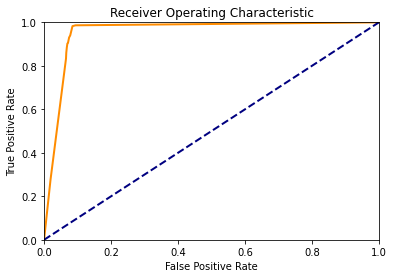

In [71]:
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show();

In [73]:
roc_auc_score(Y_test, pos_prob)

0.9589044773787905

<a name = 'cross-va' ></a>

# K-fold cross-validation and Tunning

In [75]:
# to assess the model in general:
k = 10
k_fold = StratifiedKFold(n_splits= k )
cleaned_emails_np = np.array(cleaned_emails)
labels_np = np.array(labels)

In [76]:
max_features_option = [2000, 4000, 8000]
smoothing_factor_option = [0.5, 1.0, 1.5, 2.0]
fit_prior_option = [True, False]
auc_record = {}

In [77]:
for train_indices, test_indices in k_fold.split(cleaned_emails, labels):
   X_train, X_test = cleaned_emails_np[train_indices], cleaned_emails_np[test_indices]
   Y_train, Y_test = labels_np[train_indices], labels_np[test_indices]
   for max_features in max_features_option:
     if max_features not in auc_record:
       auc_record[max_features] = {}
     cv = CountVectorizer(stop_words="english", max_features=max_features)
     term_docs_train = cv.fit_transform(X_train)
     term_docs_test = cv.transform(X_test)

     for smoothing in smoothing_factor_option:
       if smoothing not in auc_record[max_features]:
          auc_record[max_features][smoothing] = {}
       for fit_prior in fit_prior_option:
         clf = MultinomialNB(alpha=smoothing, fit_prior=fit_prior)
         clf.fit(term_docs_train, Y_train)
         prediction_prob = clf.predict_proba(term_docs_test)
         pos_prob = prediction_prob[:, 1]
         auc = roc_auc_score(Y_test, pos_prob)
         auc_record[max_features][smoothing][fit_prior] = auc + auc_record[max_features][smoothing].get(fit_prior, 0.0)



In [81]:
print('max features  smoothing  fit prior'.format(max_features, smoothing, fit_prior, auc/k))
for max_features, max_feature_record in auc_record.items():
  for smoothing, smoothing_record in max_feature_record.items():
      for fit_prior, auc in smoothing_record.items():
        print('       {0}      {1}      {2}    {3:.4f}'.format(max_features, smoothing, fit_prior, auc/k))
   


max features  smoothing  fit prior
       2000      0.5      True    0.9662
       2000      0.5      False    0.9662
       2000      1.0      True    0.9647
       2000      1.0      False    0.9646
       2000      1.5      True    0.9640
       2000      1.5      False    0.9640
       2000      2.0      True    0.9636
       2000      2.0      False    0.9635
       4000      0.5      True    0.9713
       4000      0.5      False    0.9712
       4000      1.0      True    0.9699
       4000      1.0      False    0.9698
       4000      1.5      True    0.9690
       4000      1.5      False    0.9690
       4000      2.0      True    0.9686
       4000      2.0      False    0.9686
       8000      0.5      True    0.9749
       8000      0.5      False    0.9749
       8000      1.0      True    0.9737
       8000      1.0      False    0.9736
       8000      1.5      True    0.9732
       8000      1.5      False    0.9732
       8000      2.0      True    0.9729
       8000

We can see that (8000, .5, True) and (8000, .5, False) sets enable the best AUC .9749